# ``Taming Performance Variability''

### <font color='red'> Notebook for the high-level analysis of variability.</font>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks

#import matplotlib
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

warnings.filterwarnings(action='once')

# With plot_show_and_save() defined below, there is no need for this configuration
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/raw-data/"
# Save all dataframes and plots into this directory 
dest_dir = "output/paper/"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

# db -- dictinary with keys - table names, values - dataframes with table data
db = {}

for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed throughout the notebook
verbose = True
if verbose:
    print "Keys: ", db.keys()
    for k, df in db.iteritems():
        #print "Sample from %s:" % k 
        #print df.head(3), "\n\n" 
        print "Columns in %s:" % k, df.columns.tolist(), "\n"

####  Define default graphics parameters ###

####  Include common helper functions
sys.path.append("bench-lib/")
from common import *

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Keys:  ['disk_info', 'iperf3_info', 'iperf3_results', 'ping_results', 'env_info', 'membench_info', 'disk_results', 'fio_info', 'stream_info', 'network_info', 'mem_results', 'ping_info']
Columns in disk_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'disk_name', 'disk_model', 'disk_serial', 'disk_size', 'npartitions', 'disk_type'] 

Columns in iperf3_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'version', 'local_ip', 'local_port', 'remote_ip', 'remote_port', 'remote_nodeid', 'protocol', 'num_streams', 'buffer_size', 'omitted_intervals', 'duration', 'time_units'] 

Columns in iperf3_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'reverse', 'retransmits', 'local_cpu_util', 'remote_cpu_util', 'median', 'max', 'min', 'mean', 'stdev', 'sum_sent', 'sum_received', 'units'] 

Columns in ping_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'runtime', 'packets_sent', 'packets_received', 'packet_loss', 'max', 'min', 'mean', 'stdev', 'ipg', 'ewma', 'units'] 

Colu

In [2]:
# Print high-level info 

print "The earliest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].min())
print "The latest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].max())

print "The earliest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].min())
print "The latest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].max())

print "Total number of samples: ", len(db['disk_results'])

db['disk_results'].sample(20).T 

The earliest disk perf sample:  2017-05-20 09:18:32
The latest disk perf sample:  2018-04-04 18:12:08
The earliest memory perf sample:  2017-05-20 09:18:32
The latest memory perf sample:  2018-04-04 18:12:08
Total number of samples:  141408


,49666,11714,98760,124768,65224,85982,126342,488,64337,85943,45531,115955,127229,55074,119068,75015,35659,55404,86940,127729
run_uuid,79fa4b6f-ede6-454b-91c6-7df33864bfb0,da1f2f6e-59cc-4806-bd68-747154b60e94,9db19b2b-e504-4bcd-bbdf-73e6b8a50c71,593d85cd-403b-4d52-ad67-4a133bf4e2e4,40b4b490-5cdc-4ef1-afd6-e2a9f4bc98e2,bcea4c84-9c75-4e6b-b092-18be30253ad9,4419c62d-cb09-449e-be33-54bad655450c,ad548407-4221-44e9-b94b-c9a7a0ce74cd,4c855534-5603-40c2-9836-e6e73eac749d,c41b4a89-141c-4a51-b235-e9dda662f207,27d3bacb-b6a5-4449-b317-0b0708af183b,94dfaffe-e4af-4d40-9ba9-12aa35b913ca,c3f1f3f2-3fa3-4650-97f8-6d7612ccd78e,75c24d11-bc02-4976-b27c-95b35f9b7f86,b5198457-64e9-4335-aff4-b3ca97946a44,c01a799d-5c6a-4fc6-a9e1-5a758cc4cba9,54bf3424-882f-4f66-9e43-11e2c08d7527,b94df0d6-a36b-4c9d-99a4-b938c2e03f38,b91a254b-ed18-44af-9b6d-4aeebbdaaf56,30bd1bec-40a9-4107-868c-08225f516adc
timestamp,1502109966,1497077236,1514727968,1519931515,1506191249,1512306428,1520190796,1495497937,1505930735,1512287236,1501590504,1517903351,1520428314,1503189961,1518829918,1509930348,1500208046,1503232065,1512458861,1520601122
nodeid,clnode036,clnode162,clnode028,ms0103,c220g2-011022,ms0208,ms1320,ms0135,ms0745,clnode022,c220g2-011318,clnode145,ms0315,clnode065,ms0738,ms1328,c220g2-010823,c220g2-011005,c220g2-011128,ms0235
nodeuuid,d09d16f9-d7f1-11e4-b34b-000099989701,15f68ae4-fee4-11e5-ba07-000099989701,cfdd6ac7-d7f1-11e4-b34b-000099989701,ed796a1d-72d4-11e4-85c8-179a28bd1b8c,17ce204f-e8ec-11e5-a488-a3bb994732a6,69c6ea66-72da-11e4-85c8-179a28bd1b8c,e28bb291-8ffe-11e6-8c08-a53a3a50acf8,468308e6-72d5-11e4-85c8-179a28bd1b8c,bc04d999-74c8-11e4-85c8-179a28bd1b8c,cf65a9a4-d7f1-11e4-b34b-000099989701,18fc3782-e8ec-11e5-a488-a3bb994732a6,90512d24-fee3-11e5-ba07-000099989701,311541c0-72db-11e4-85c8-179a28bd1b8c,d31f42ca-d7f1-11e4-b34b-000099989701,bab0f78e-74c8-11e4-85c8-179a28bd1b8c,e469f072-8ffe-11e6-8c08-a53a3a50acf8,20acf8f2-e772-11e5-a488-a3bb994732a6,1ab7f7c1-e8ec-11e5-a488-a3bb994732a6,50affc6c-e8d4-11e5-a488-a3bb994732a6,67346afd-72da-11e4-85c8-179a28bd1b8c
testname,write,randread,randwrite,randwrite,read,read,read,randwrite,randread,randread,read,randread,read,randread,randread,randwrite,write,randwrite,randwrite,randread
runtime,101.861,720.379,720.353,720.002,21.069,147.581,55.88,720.002,105.913,720.006,118.02,720.342,54.689,720.345,140.717,16.176,57.38,45.215,45.055,106.355
size,1.04858e+07,1.20307e+06,1.30612e+06,1.42008e+06,1.04858e+07,1.04858e+07,1.04858e+07,1.43195e+06,1.04858e+07,440560,1.04858e+07,1.41405e+06,1.04858e+07,1.35619e+06,1.04858e+07,1.04858e+07,1.04858e+07,1.04858e+07,1.04858e+07,1.04858e+07
max,118666,2161,2392,2019,498984,76808,243856,2024,181304,733,95064,2488,196224,2536,103152,789136,192256,248880,259368,178384
min,21486,0,0,1832,492520,1516,160032,1848,7,270,86288,0,187784,0,26696,306360,149096,196968,200168,7
mean,103195,1671.32,1813.68,1974.06,497899,71063.8,187717,1990.46,98874.6,611.975,88852.1,1963.54,191844,1881.08,74483,645754,182493,231449,232414,98298.3


In [3]:
raw_disk_all, disk_all = process_disk(db)
raw_mem_all, mem_all = process_memory(db)
raw_net_all, net_all = process_network(db)

In [4]:
# Iterate over all possible configurations

print "Disk"
#for idx, grp in disk_all.groupby(["site", "hw_type", "device", "disk_type", "disk_model", "disk_size"]):
c = 0
for idx, grp in disk_all.groupby(["site", "hw_type", "device", "testname", "iodepth"]):
    print idx, len(grp) 
    c += 1
print "Count:", c

print "\nMemory"
c = 0
for idx, grp in mem_all.groupby(["site", "hw_type", "testname", "dvfs", "socket_num"]):
    print idx, len(grp)
    c += 1
print "Count:", c
    
print "\nNetwork:"
c = 0
for idx, grp in net_all.groupby(["site", "hw_type", "rack_local", "test", "directionality"]):
    print idx, len(grp)
    c += 1
print "Count:", c

Disk
('clemson', 'c6320', '/dev/sda4', 'randread', 1) 741
('clemson', 'c6320', '/dev/sda4', 'randread', 4096) 741
('clemson', 'c6320', '/dev/sda4', 'randwrite', 1) 741
('clemson', 'c6320', '/dev/sda4', 'randwrite', 4096) 741
('clemson', 'c6320', '/dev/sda4', 'read', 1) 741
('clemson', 'c6320', '/dev/sda4', 'read', 4096) 741
('clemson', 'c6320', '/dev/sda4', 'write', 1) 741
('clemson', 'c6320', '/dev/sda4', 'write', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'randread', 1) 741
('clemson', 'c6320', '/dev/sdb', 'randread', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'randwrite', 1) 741
('clemson', 'c6320', '/dev/sdb', 'randwrite', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'read', 1) 741
('clemson', 'c6320', '/dev/sdb', 'read', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'write', 1) 741
('clemson', 'c6320', '/dev/sdb', 'write', 4096) 741
('clemson', 'c8220', '/dev/sda4', 'randread', 1) 1742
('clemson', 'c8220', '/dev/sda4', 'randread', 4096) 1742
('clemson', 'c8220', '/dev/sda4', 'randwrite

In [5]:
metric = "mean"
show_count = 10

# ----
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD"])
for idx, grp in disk_all.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for disks:"    
display(disk_var_summary.sort_values("RSD", ascending=True).head(show_count))

# ----
mem_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD"])
for idx, grp in mem_all.groupby(["site", "hw_type", "testname", "dvfs", "socket_num"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    mem_var_summary.loc[len(mem_var_summary)] = ["Memory", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 

print "\n\nHighest RSD for memory:"    
display(mem_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for memory:"    
display(mem_var_summary.sort_values("RSD", ascending=True).head(show_count))

# ----
net_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD"])
for idx, grp in net_all.groupby(["site", "hw_type", "rack_local", "test", "directionality"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    net_var_summary.loc[len(net_var_summary)] = ["Network", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 

print "\n\nHighest RSD for network:"    
display(net_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for network:"    
display(net_var_summary.sort_values("RSD", ascending=True).head(show_count))

Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
54,Disk,"[wisc, c220g1, /dev/sda4, write, 1]",wisc,c220g1,751,1640.154105,9744.933016,594.147403
35,Disk,"[utah, m400, /dev/sda2, randwrite, 4096]",utah,m400,3566,2915.537863,10576.674364,362.769234
38,Disk,"[utah, m400, /dev/sda2, write, 1]",utah,m400,3566,2733.429226,8696.932351,318.169290
34,Disk,"[utah, m400, /dev/sda2, randwrite, 1]",utah,m400,3566,2722.792420,8595.138328,315.673654
50,Disk,"[wisc, c220g1, /dev/sda4, randwrite, 1]",wisc,c220g1,751,912.179164,175.698829,19.261439
88,Disk,"[wisc, c220g2, /dev/sdc, randread, 1]",wisc,c220g2,1480,29295.269257,3006.167786,10.261615
64,Disk,"[wisc, c220g1, /dev/sdc, randread, 1]",wisc,c220g1,765,29938.751242,2970.017237,9.920311
19,Disk,"[clemson, c8220, /dev/sda4, randwrite, 4096]",clemson,c8220,1742,1759.165413,148.065037,8.416777
17,Disk,"[clemson, c8220, /dev/sda4, randread, 4096]",clemson,c8220,1742,1881.122669,152.788284,8.122186
8,Disk,"[clemson, c6320, /dev/sdb, randread, 1]",clemson,c6320,741,598.931846,48.466120,8.092093




Lowest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
65,Disk,"[wisc, c220g1, /dev/sdc, randread, 4096]",wisc,c220g1,765,305628.045752,288.509973,0.094399
62,Disk,"[wisc, c220g1, /dev/sdb, write, 1]",wisc,c220g1,763,697.141666,1.002406,0.143788
72,Disk,"[wisc, c220g2, /dev/sda4, randread, 1]",wisc,c220g2,1479,936.836794,4.223361,0.450811
80,Disk,"[wisc, c220g2, /dev/sdb, randread, 1]",wisc,c220g2,1479,938.366754,4.392374,0.468087
91,Disk,"[wisc, c220g2, /dev/sdc, randwrite, 4096]",wisc,c220g2,1480,233037.622297,1209.854961,0.519167
67,Disk,"[wisc, c220g1, /dev/sdc, randwrite, 4096]",wisc,c220g1,765,234180.296732,1252.107054,0.534677
56,Disk,"[wisc, c220g1, /dev/sdb, randread, 1]",wisc,c220g1,763,1006.706328,5.801790,0.576314
89,Disk,"[wisc, c220g2, /dev/sdc, randread, 4096]",wisc,c220g2,1480,305379.608108,1820.020408,0.595986
48,Disk,"[wisc, c220g1, /dev/sda4, randread, 1]",wisc,c220g1,751,1003.636302,6.567493,0.654370
69,Disk,"[wisc, c220g1, /dev/sdc, read, 4096]",wisc,c220g1,765,489668.043137,3276.814951,0.669191




Highest RSD for memory:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
76,Memory,"[clemson, c6320, write_memory_avx_omp, no, 0]",clemson,c6320,623,22452.784398,8132.227414,36.219238
124,Memory,"[clemson, c6320, write_memory_sse_omp, no, 0]",clemson,c6320,623,22422.721091,8120.925640,36.217396
69,Memory,"[clemson, c6320, triad_omp, no, 1]",clemson,c6320,623,37425.485506,13491.360060,36.048591
5,Memory,"[clemson, c6320, add_omp, no, 1]",clemson,c6320,623,36597.355377,13186.550535,36.031430
77,Memory,"[clemson, c6320, write_memory_avx_omp, no, 1]",clemson,c6320,623,22330.460915,8045.427478,36.028936
125,Memory,"[clemson, c6320, write_memory_sse_omp, no, 1]",clemson,c6320,623,22309.206453,8032.581243,36.005679
4,Memory,"[clemson, c6320, add_omp, no, 0]",clemson,c6320,623,36574.218796,13130.894191,35.902050
68,Memory,"[clemson, c6320, triad_omp, no, 0]",clemson,c6320,623,37393.337608,13415.556769,35.876864
61,Memory,"[clemson, c6320, scale_omp, no, 1]",clemson,c6320,623,32810.001332,11766.080513,35.861262
84,Memory,"[clemson, c6320, write_memory_loop_omp, no, 0]",clemson,c6320,623,22482.378571,8060.157818,35.851001




Lowest RSD for memory:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
441,Memory,"[wisc, c220g1, write_memory_nontemporal_sse, y...",wisc,c220g1,768,18555.537760,6.201308,0.033420
433,Memory,"[wisc, c220g1, write_memory_nontemporal_avx, y...",wisc,c220g1,768,18556.355859,6.394093,0.034458
318,Memory,"[utah, m510, write_memory_nontemporal_avx, no, 0]",utah,m510,1822,11589.053403,5.010260,0.043233
157,Memory,"[clemson, c8220, read_memory_loop_omp, no, 1]",clemson,c8220,1576,39200.642576,17.636918,0.044991
156,Memory,"[clemson, c8220, read_memory_loop_omp, no, 0]",clemson,c8220,1576,39135.914213,23.618471,0.060350
183,Memory,"[clemson, c8220, read_memory_sse_omp, yes, 1]",clemson,c8220,1742,39288.126980,24.336668,0.061944
193,Memory,"[clemson, c8220, triad, no, 1]",clemson,c8220,1576,11303.776459,7.708462,0.068194
192,Memory,"[clemson, c8220, triad, no, 0]",clemson,c8220,1576,11313.073604,8.301284,0.073378
180,Memory,"[clemson, c8220, read_memory_sse_omp, no, 0]",clemson,c8220,1576,39199.676650,28.856430,0.073614
322,Memory,"[utah, m510, write_memory_nontemporal_sse, no, 0]",utah,m510,1822,11588.669155,8.630962,0.074478




Highest RSD for network:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
23,Network,"[wisc, c220g1, True, latency, forward]",wisc,c220g1,70,2.630000e-02,7.669533e-03,29.161723
5,Network,"[clemson, c8220, False, latency, forward]",clemson,c8220,284,3.523239e-02,8.396251e-03,23.831056
8,Network,"[clemson, c8220, True, latency, forward]",clemson,c8220,404,3.097277e-02,6.949427e-03,22.437215
2,Network,"[clemson, c6320, False, latency, forward]",clemson,c6320,371,3.499191e-02,7.669697e-03,21.918485
20,Network,"[wisc, c220g1, False, latency, forward]",wisc,c220g1,294,2.851701e-02,5.853564e-03,20.526573
13,Network,"[utah, m510, False, bandwidth, reverse]",utah,m510,802,9.087738e+09,1.578602e+09,17.370677
26,Network,"[wisc, c220g2, False, latency, forward]",wisc,c220g2,415,2.796145e-02,4.703114e-03,16.819996
11,Network,"[utah, m400, False, latency, forward]",utah,m400,1193,2.834367e-02,3.499652e-03,12.347207
10,Network,"[utah, m400, False, bandwidth, reverse]",utah,m400,1193,6.008693e+09,6.142685e+08,10.222998
17,Network,"[utah, m510, True, latency, forward]",utah,m510,189,1.612698e-02,1.453083e-03,9.010256




Lowest RSD for network:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
7,Network,"[clemson, c8220, True, bandwidth, reverse]",clemson,c8220,404,9.390098e+09,3.293070e+05,0.003507
25,Network,"[wisc, c220g2, False, bandwidth, reverse]",wisc,c220g2,415,9.389822e+09,6.957641e+05,0.007410
22,Network,"[wisc, c220g1, True, bandwidth, reverse]",wisc,c220g1,70,9.389870e+09,7.126497e+05,0.007590
6,Network,"[clemson, c8220, True, bandwidth, forward]",clemson,c8220,404,9.389156e+09,7.193763e+05,0.007662
3,Network,"[clemson, c8220, False, bandwidth, forward]",clemson,c8220,284,9.388897e+09,9.216804e+05,0.009817
4,Network,"[clemson, c8220, False, bandwidth, reverse]",clemson,c8220,284,9.389475e+09,9.294417e+05,0.009899
21,Network,"[wisc, c220g1, True, bandwidth, forward]",wisc,c220g1,70,9.389332e+09,1.461056e+06,0.015561
24,Network,"[wisc, c220g2, False, bandwidth, forward]",wisc,c220g2,415,9.389530e+09,1.537012e+06,0.016369
18,Network,"[wisc, c220g1, False, bandwidth, forward]",wisc,c220g1,294,9.389401e+09,1.754778e+06,0.018689
16,Network,"[utah, m510, True, bandwidth, reverse]",utah,m510,189,9.366828e+09,5.181124e+06,0.055314


In [6]:
show_count = 50

all_summary = pd.concat([disk_var_summary, mem_var_summary, net_var_summary])

print "\n\nHighest RSD for all:"    
display(all_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for all:"    
display(all_summary.sort_values("RSD", ascending=True).head(show_count))



Highest RSD for all:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
54,Disk,"[wisc, c220g1, /dev/sda4, write, 1]",wisc,c220g1,751,1640.154105,9744.933016,594.147403
35,Disk,"[utah, m400, /dev/sda2, randwrite, 4096]",utah,m400,3566,2915.537863,10576.674364,362.769234
38,Disk,"[utah, m400, /dev/sda2, write, 1]",utah,m400,3566,2733.429226,8696.932351,318.169290
34,Disk,"[utah, m400, /dev/sda2, randwrite, 1]",utah,m400,3566,2722.792420,8595.138328,315.673654
76,Memory,"[clemson, c6320, write_memory_avx_omp, no, 0]",clemson,c6320,623,22452.784398,8132.227414,36.219238
124,Memory,"[clemson, c6320, write_memory_sse_omp, no, 0]",clemson,c6320,623,22422.721091,8120.925640,36.217396
69,Memory,"[clemson, c6320, triad_omp, no, 1]",clemson,c6320,623,37425.485506,13491.360060,36.048591
5,Memory,"[clemson, c6320, add_omp, no, 1]",clemson,c6320,623,36597.355377,13186.550535,36.031430
77,Memory,"[clemson, c6320, write_memory_avx_omp, no, 1]",clemson,c6320,623,22330.460915,8045.427478,36.028936
125,Memory,"[clemson, c6320, write_memory_sse_omp, no, 1]",clemson,c6320,623,22309.206453,8032.581243,36.005679




Lowest RSD for all:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD
7,Network,"[clemson, c8220, True, bandwidth, reverse]",clemson,c8220,404,9.390098e+09,3.293070e+05,0.003507
25,Network,"[wisc, c220g2, False, bandwidth, reverse]",wisc,c220g2,415,9.389822e+09,6.957641e+05,0.007410
22,Network,"[wisc, c220g1, True, bandwidth, reverse]",wisc,c220g1,70,9.389870e+09,7.126497e+05,0.007590
6,Network,"[clemson, c8220, True, bandwidth, forward]",clemson,c8220,404,9.389156e+09,7.193763e+05,0.007662
3,Network,"[clemson, c8220, False, bandwidth, forward]",clemson,c8220,284,9.388897e+09,9.216804e+05,0.009817
4,Network,"[clemson, c8220, False, bandwidth, reverse]",clemson,c8220,284,9.389475e+09,9.294417e+05,0.009899
21,Network,"[wisc, c220g1, True, bandwidth, forward]",wisc,c220g1,70,9.389332e+09,1.461056e+06,0.015561
24,Network,"[wisc, c220g2, False, bandwidth, forward]",wisc,c220g2,415,9.389530e+09,1.537012e+06,0.016369
18,Network,"[wisc, c220g1, False, bandwidth, forward]",wisc,c220g1,294,9.389401e+09,1.754778e+06,0.018689
441,Memory,"[wisc, c220g1, write_memory_nontemporal_sse, y...",wisc,c220g1,768,1.855554e+04,6.201308e+00,0.033420


In [7]:
# Use kernel testing (in another notebook), find 3 the least representative nodes for each hardware type and exclude them

node_black_list = {"c220g1-030808", "c220g1-030815", "c220g1-030609", 
                   "c220g2-011312", "c220g2-011324", "c220g2-011323", 
                   "ms0708", "ms0710", "ms0739",
                   "ms0908", "ms1315", "ms1324",
                   "clnode135", "clnode137", "clnode169",
                   "clnode036", "clnode094", "clnode032"}

metric = "mean"
show_count = 10

disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "SampleCount", "Mean", "SD", "RSD", "RSD_3_Outlier_Removed", "RSD_Change"])
for idx, grp in disk_all.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 
    
print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLargest RSD_Change for disks:"    
display(disk_var_summary.sort_values("RSD_Change", ascending=True).head(show_count))

# ----

mem_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "SampleCount", "Mean", "SD", "RSD", "RSD_3_Outlier_Removed", "RSD_Change"])
for idx, grp in mem_all.groupby(["site", "hw_type", "testname", "dvfs", "socket_num"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    mem_var_summary.loc[len(mem_var_summary)] = ["Memory", list(idx), idx[0], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 
    
print "Highest RSD for memory:"    
display(mem_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLargest RSD_Change for memory:"    
display(mem_var_summary.sort_values("RSD_Change", ascending=True).head(show_count))

# ----

net_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "SampleCount", "Mean", "SD", "RSD", "RSD_3_Outlier_Removed", "RSD_Change"])
for idx, grp in net_all.groupby(["site", "hw_type", "rack_local", "test", "directionality"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    net_var_summary.loc[len(net_var_summary)] = ["Network", list(idx), idx[0], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 
    
print "Highest RSD for network:"    
display(net_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLargest RSD_Change for network:"    
display(net_var_summary.sort_values("RSD_Change", ascending=True).head(show_count))

Highest RSD for disks:


,Type,Config,Site,SampleCount,Mean,SD,RSD,RSD_3_Outlier_Removed,RSD_Change
54,Disk,"[wisc, c220g1, /dev/sda4, write, 1]",wisc,751,1640.154105,9744.933016,594.147403,590.575037,-3.572366
35,Disk,"[utah, m400, /dev/sda2, randwrite, 4096]",utah,3566,2915.537863,10576.674364,362.769234,245.508394,-117.260840
38,Disk,"[utah, m400, /dev/sda2, write, 1]",utah,3566,2733.429226,8696.932351,318.169290,208.436330,-109.732960
34,Disk,"[utah, m400, /dev/sda2, randwrite, 1]",utah,3566,2722.792420,8595.138328,315.673654,206.364445,-109.309209
50,Disk,"[wisc, c220g1, /dev/sda4, randwrite, 1]",wisc,751,912.179164,175.698829,19.261439,19.891684,0.630246
88,Disk,"[wisc, c220g2, /dev/sdc, randread, 1]",wisc,1480,29295.269257,3006.167786,10.261615,10.724653,0.463038
64,Disk,"[wisc, c220g1, /dev/sdc, randread, 1]",wisc,765,29938.751242,2970.017237,9.920311,9.896156,-0.024155
19,Disk,"[clemson, c8220, /dev/sda4, randwrite, 4096]",clemson,1742,1759.165413,148.065037,8.416777,7.836293,-0.580484
17,Disk,"[clemson, c8220, /dev/sda4, randread, 4096]",clemson,1742,1881.122669,152.788284,8.122186,7.033192,-1.088994
8,Disk,"[clemson, c6320, /dev/sdb, randread, 1]",clemson,741,598.931846,48.466120,8.092093,8.193094,0.101001




Largest RSD_Change for disks:


,Type,Config,Site,SampleCount,Mean,SD,RSD,RSD_3_Outlier_Removed,RSD_Change
35,Disk,"[utah, m400, /dev/sda2, randwrite, 4096]",utah,3566,2915.537863,10576.674364,362.769234,245.508394,-117.260840
38,Disk,"[utah, m400, /dev/sda2, write, 1]",utah,3566,2733.429226,8696.932351,318.169290,208.436330,-109.732960
34,Disk,"[utah, m400, /dev/sda2, randwrite, 1]",utah,3566,2722.792420,8595.138328,315.673654,206.364445,-109.309209
54,Disk,"[wisc, c220g1, /dev/sda4, write, 1]",wisc,751,1640.154105,9744.933016,594.147403,590.575037,-3.572366
33,Disk,"[utah, m400, /dev/sda2, randread, 4096]",utah,3566,97985.256225,6441.059864,6.573499,4.661985,-1.911514
36,Disk,"[utah, m400, /dev/sda2, read, 1]",utah,3566,74719.263657,4877.748399,6.528100,4.807492,-1.720608
17,Disk,"[clemson, c8220, /dev/sda4, randread, 4096]",clemson,1742,1881.122669,152.788284,8.122186,7.033192,-1.088994
32,Disk,"[utah, m400, /dev/sda2, randread, 1]",utah,3566,73864.292961,3674.978978,4.975312,4.038883,-0.936429
3,Disk,"[clemson, c6320, /dev/sda4, randwrite, 4096]",clemson,741,1748.727530,139.633208,7.984846,7.112908,-0.871939
16,Disk,"[clemson, c8220, /dev/sda4, randread, 1]",clemson,1742,647.555499,30.378852,4.691313,3.879005,-0.812308


Highest RSD for memory:


,Type,Config,Site,SampleCount,Mean,SD,RSD,RSD_3_Outlier_Removed,RSD_Change
76,Memory,"[clemson, c6320, write_memory_avx_omp, no, 0]",clemson,623,22452.784398,8132.227414,36.219238,31.464110,-4.755128
124,Memory,"[clemson, c6320, write_memory_sse_omp, no, 0]",clemson,623,22422.721091,8120.925640,36.217396,31.473571,-4.743825
69,Memory,"[clemson, c6320, triad_omp, no, 1]",clemson,623,37425.485506,13491.360060,36.048591,31.109022,-4.939569
5,Memory,"[clemson, c6320, add_omp, no, 1]",clemson,623,36597.355377,13186.550535,36.031430,31.089521,-4.941909
77,Memory,"[clemson, c6320, write_memory_avx_omp, no, 1]",clemson,623,22330.460915,8045.427478,36.028936,31.106264,-4.922672
125,Memory,"[clemson, c6320, write_memory_sse_omp, no, 1]",clemson,623,22309.206453,8032.581243,36.005679,31.088452,-4.917227
4,Memory,"[clemson, c6320, add_omp, no, 0]",clemson,623,36574.218796,13130.894191,35.902050,31.006810,-4.895239
68,Memory,"[clemson, c6320, triad_omp, no, 0]",clemson,623,37393.337608,13415.556769,35.876864,30.979683,-4.897181
61,Memory,"[clemson, c6320, scale_omp, no, 1]",clemson,623,32810.001332,11766.080513,35.861262,30.926550,-4.934712
84,Memory,"[clemson, c6320, write_memory_loop_omp, no, 0]",clemson,623,22482.378571,8060.157818,35.851001,31.047031,-4.803970




Largest RSD_Change for memory:


,Type,Config,Site,SampleCount,Mean,SD,RSD,RSD_3_Outlier_Removed,RSD_Change
502,Memory,"[wisc, c220g2, read_memory_rep_lodsq, no, 0]",wisc,1297,7937.600971,1425.243978,17.955601,2.796715,-15.158886
463,Memory,"[wisc, c220g2, add, no, 1]",wisc,1297,9849.631457,1533.050395,15.564546,0.512940,-15.051606
527,Memory,"[wisc, c220g2, triad, no, 1]",wisc,1297,9864.673616,1548.054486,15.692911,0.684799,-15.008112
462,Memory,"[wisc, c220g2, add, no, 0]",wisc,1297,10173.982274,1619.416561,15.917234,1.177051,-14.740183
526,Memory,"[wisc, c220g2, triad, no, 0]",wisc,1297,10155.424649,1627.695979,16.027848,1.313420,-14.714427
471,Memory,"[wisc, c220g2, copy, no, 1]",wisc,1297,8835.465852,1321.787260,14.960018,0.473065,-14.486952
503,Memory,"[wisc, c220g2, read_memory_rep_lodsq, no, 1]",wisc,1297,7941.167702,1431.114692,18.021464,3.610440,-14.411025
470,Memory,"[wisc, c220g2, copy, no, 0]",wisc,1297,9119.900208,1395.893178,15.306014,1.239233,-14.066781
504,Memory,"[wisc, c220g2, read_memory_rep_lodsq, yes, 0]",wisc,1483,9858.347950,1665.194474,16.891212,3.247731,-13.643482
505,Memory,"[wisc, c220g2, read_memory_rep_lodsq, yes, 1]",wisc,1483,9985.614943,1700.834038,17.032842,3.881829,-13.151013


Highest RSD for network:


,Type,Config,Site,SampleCount,Mean,SD,RSD,RSD_3_Outlier_Removed,RSD_Change
23,Network,"[wisc, c220g1, True, latency, forward]",wisc,70,2.630000e-02,7.669533e-03,29.161723,29.617975,0.456251
5,Network,"[clemson, c8220, False, latency, forward]",clemson,284,3.523239e-02,8.396251e-03,23.831056,24.287304,0.456248
8,Network,"[clemson, c8220, True, latency, forward]",clemson,404,3.097277e-02,6.949427e-03,22.437215,22.568032,0.130817
2,Network,"[clemson, c6320, False, latency, forward]",clemson,371,3.499191e-02,7.669697e-03,21.918485,22.310343,0.391858
20,Network,"[wisc, c220g1, False, latency, forward]",wisc,294,2.851701e-02,5.853564e-03,20.526573,20.825914,0.299341
13,Network,"[utah, m510, False, bandwidth, reverse]",utah,802,9.087738e+09,1.578602e+09,17.370677,17.472080,0.101403
26,Network,"[wisc, c220g2, False, latency, forward]",wisc,415,2.796145e-02,4.703114e-03,16.819996,16.844681,0.024685
11,Network,"[utah, m400, False, latency, forward]",utah,1193,2.834367e-02,3.499652e-03,12.347207,12.412220,0.065013
10,Network,"[utah, m400, False, bandwidth, reverse]",utah,1193,6.008693e+09,6.142685e+08,10.222998,10.006985,-0.216013
17,Network,"[utah, m510, True, latency, forward]",utah,189,1.612698e-02,1.453083e-03,9.010256,8.941004,-0.069252




Largest RSD_Change for network:


,Type,Config,Site,SampleCount,Mean,SD,RSD,RSD_3_Outlier_Removed,RSD_Change
10,Network,"[utah, m400, False, bandwidth, reverse]",utah,1193,6.008693e+09,6.142685e+08,10.222998,10.006985,-0.216013
17,Network,"[utah, m510, True, latency, forward]",utah,189,1.612698e-02,1.453083e-03,9.010256,8.941004,-0.069252
9,Network,"[utah, m400, False, bandwidth, forward]",utah,1193,9.298073e+09,5.865747e+08,6.308562,6.303778,-0.004783
1,Network,"[clemson, c6320, False, bandwidth, reverse]",clemson,371,9.386558e+09,7.679253e+06,0.081811,0.078703,-0.003109
12,Network,"[utah, m510, False, bandwidth, forward]",utah,802,9.365192e+09,5.470714e+06,0.058415,0.056644,-0.001771
7,Network,"[clemson, c8220, True, bandwidth, reverse]",clemson,404,9.390098e+09,3.293070e+05,0.003507,0.003480,-0.000027
4,Network,"[clemson, c8220, False, bandwidth, reverse]",clemson,284,9.389475e+09,9.294417e+05,0.009899,0.009874,-0.000025
6,Network,"[clemson, c8220, True, bandwidth, forward]",clemson,404,9.389156e+09,7.193763e+05,0.007662,0.007664,0.000002
25,Network,"[wisc, c220g2, False, bandwidth, reverse]",wisc,415,9.389822e+09,6.957641e+05,0.007410,0.007443,0.000033
24,Network,"[wisc, c220g2, False, bandwidth, forward]",wisc,415,9.389530e+09,1.537012e+06,0.016369,0.016425,0.000056


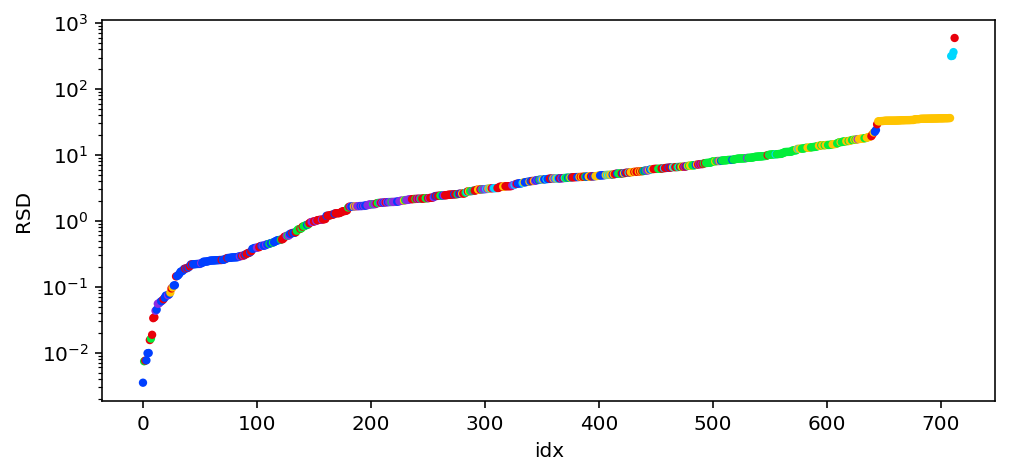

In [8]:
# Show RSD for all configs

fig, ax = plt.subplots(figsize=(8,3.5))
all_summary_sorted = all_summary.sort_values("RSD")
all_summary_sorted["idx"] = range(len(all_summary_sorted))

color_map = get_cmap(all_summary_sorted, "HW")
point_color = all_summary_sorted["HW"].map(color_map)

all_summary_sorted.plot(x = "idx", y="RSD", kind="scatter", color=point_color, s = 10, marker="o", ax=ax, logy=True)
plt.show()

In [202]:
# Based on kernel analysis, # of excluded nodes for each h_type:
# m510: 5
# c8220: 2
# m400: 7
# c220g2: 4
# c220g1: 2
# c6320: 2

node_black_list = {"c220g1-030808", "c220g1-030815", # c220g1
                   "c220g2-011312", "c220g2-011324", "c220g2-011323", "c220g2-011311", # c220g2
                   "ms0708", "ms0710", "ms0739", "ms0719", "ms0734", "ms0406", "ms0741", # m400
                   "ms0908", "ms1315", "ms1324", "ms0914", "ms0836", # m510
                   "clnode135", "clnode137", # c6320
                   "clnode036", "clnode094"} # c8220

disk_subset = subset_df(disk_all, {"iodepth": 4096})
hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sda4",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 5

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for disks:"    
display(disk_var_summary.sort_values("RSD", ascending=True).head(show_count))

# # ----
# 'add', 'add_omp', 'copy', 'copy_omp', 'triad', 'triad_omp', 'read_memory_avx', 'write_memory_avx'
mem_subset = mem_all[mem_all["testname"].isin(['copy'])]

c = 0
mem_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in mem_subset.groupby(["site", "hw_type", "testname", "dvfs", "socket_num"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #mem_var_summary.loc[len(mem_var_summary)] = ["Memory", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    mem_var_summary.loc[len(mem_var_summary)] = ["Memory", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied memory configs:", c

print "\n\nHighest RSD for memory:"    
display(mem_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for memory:"    
display(mem_var_summary.sort_values("RSD", ascending=True).head(show_count))

# ----
c = 0
net_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in net_all.groupby(["site", "hw_type", "rack_local", "test", "directionality"]): 
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #net_var_summary.loc[len(net_var_summary)] = ["Network", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    net_var_summary.loc[len(net_var_summary)] = ["Network", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 
    
    c += 1
    
print "Number of studied network configs:", c

print "\n\nHighest RSD for network:"    
display(net_var_summary.sort_values("RSD", ascending=False).head(show_count))

print "\n\nLowest RSD for network:"    
display(net_var_summary.sort_values("RSD", ascending=True).head(show_count))

Number of studied disk configs: 24
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
9,Disk,"[utah, m400, /dev/sda2, randwrite, 4096]",utah,m400,3566,2915.537863,10576.674364,362.769234,1.069353,-361.699880
5,Disk,"[clemson, c8220, /dev/sda4, randwrite, 4096]",clemson,c8220,1742,1759.165413,148.065037,8.416777,7.904012,-0.512765
4,Disk,"[clemson, c8220, /dev/sda4, randread, 4096]",clemson,c8220,1742,1881.122669,152.788284,8.122186,7.221548,-0.900639
1,Disk,"[clemson, c6320, /dev/sda4, randwrite, 4096]",clemson,c6320,741,1748.727530,139.633208,7.984846,7.036404,-0.948442
8,Disk,"[utah, m400, /dev/sda2, randread, 4096]",utah,m400,3566,97985.256225,6441.059864,6.573499,1.414080,-5.159419




Lowest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
16,Disk,"[wisc, c220g1, /dev/sda4, randread, 4096]",wisc,c220g1,751,3667.224234,52.913992,1.442889,1.448153,0.005263
21,Disk,"[wisc, c220g2, /dev/sda4, randwrite, 4096]",wisc,c220g2,1479,2640.941501,42.072579,1.593090,1.591841,-0.001249
18,Disk,"[wisc, c220g1, /dev/sda4, read, 4096]",wisc,c220g1,751,199792.676431,3277.983597,1.640693,1.655543,0.014851
2,Disk,"[clemson, c6320, /dev/sda4, read, 4096]",clemson,c6320,741,114150.377868,1890.163092,1.655854,1.701957,0.046104
3,Disk,"[clemson, c6320, /dev/sda4, write, 4096]",clemson,c6320,741,106119.225371,1769.837540,1.667782,1.709198,0.041416


Number of studied memory configs: 19


Highest RSD for memory:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
2,Memory,"[clemson, c6320, copy, yes, 0]",clemson,c6320,741,9840.549568,1741.804924,17.700281,16.006710,-1.693571
3,Memory,"[clemson, c6320, copy, yes, 1]",clemson,c6320,741,9810.134157,1730.784992,17.642827,15.889956,-1.752871
0,Memory,"[clemson, c6320, copy, no, 0]",clemson,c6320,623,9020.895457,1474.153324,16.341541,14.784942,-1.556599
1,Memory,"[clemson, c6320, copy, no, 1]",clemson,c6320,623,9044.554799,1460.540743,16.148288,14.489826,-1.658461
15,Memory,"[wisc, c220g2, copy, no, 0]",wisc,c220g2,1297,9119.900208,1395.893178,15.306014,1.238216,-14.067798




Lowest RSD for memory:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
4,Memory,"[clemson, c8220, copy, no, 0]",clemson,c8220,1576,10069.640533,25.918321,0.257391,0.255846,-0.001544
5,Memory,"[clemson, c8220, copy, no, 1]",clemson,c8220,1576,10063.997893,26.375310,0.262076,0.262190,0.000115
9,Memory,"[utah, m510, copy, no, 0]",utah,m510,1822,9656.491888,100.957331,1.045487,1.045880,0.000394
10,Memory,"[utah, m510, copy, yes, 0]",utah,m510,2007,10590.246158,241.369067,2.279164,2.001572,-0.277592
7,Memory,"[clemson, c8220, copy, yes, 1]",clemson,c8220,1742,10149.866102,419.778712,4.135805,3.956996,-0.178809


Number of studied network configs: 27


Highest RSD for network:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
23,Network,"[wisc, c220g1, True, latency, forward]",wisc,c220g1,70,0.026300,0.007670,29.161723,29.161723,0.000000
5,Network,"[clemson, c8220, False, latency, forward]",clemson,c8220,284,0.035232,0.008396,23.831056,24.088323,0.257267
8,Network,"[clemson, c8220, True, latency, forward]",clemson,c8220,404,0.030973,0.006949,22.437215,22.568032,0.130817
2,Network,"[clemson, c6320, False, latency, forward]",clemson,c6320,371,0.034992,0.007670,21.918485,22.171814,0.253329
20,Network,"[wisc, c220g1, False, latency, forward]",wisc,c220g1,294,0.028517,0.005854,20.526573,20.825914,0.299341




Lowest RSD for network:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
7,Network,"[clemson, c8220, True, bandwidth, reverse]",clemson,c8220,404,9.390098e+09,329307.036018,0.003507,0.003480,-0.000027
25,Network,"[wisc, c220g2, False, bandwidth, reverse]",wisc,c220g2,415,9.389822e+09,695764.131829,0.007410,0.007453,0.000043
22,Network,"[wisc, c220g1, True, bandwidth, reverse]",wisc,c220g1,70,9.389870e+09,712649.679167,0.007590,0.007590,0.000000
6,Network,"[clemson, c8220, True, bandwidth, forward]",clemson,c8220,404,9.389156e+09,719376.304618,0.007662,0.007664,0.000002
3,Network,"[clemson, c8220, False, bandwidth, forward]",clemson,c8220,284,9.388897e+09,921680.391022,0.009817,0.009911,0.000094


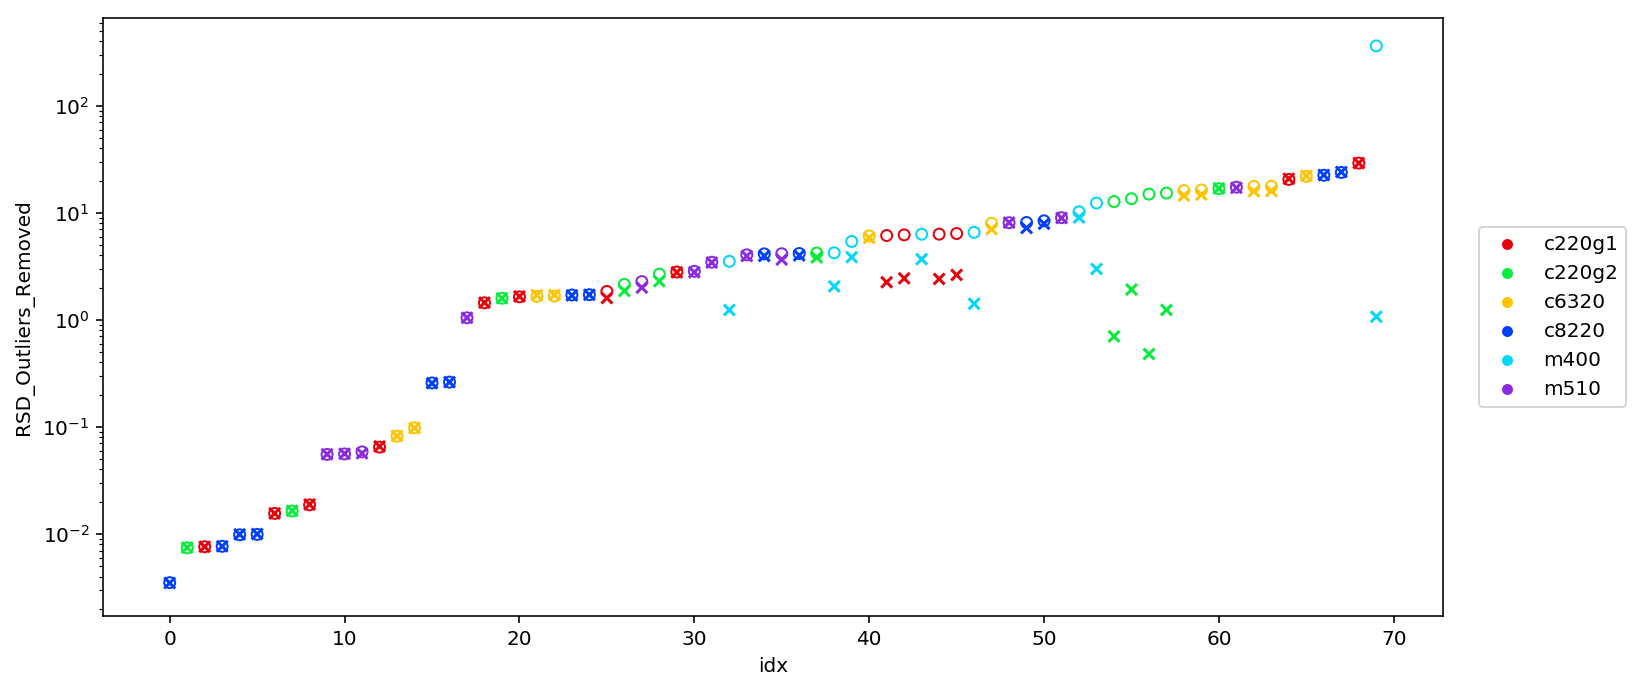

In [203]:
# Colored by hw_type

all_summary = pd.concat([disk_var_summary, mem_var_summary, net_var_summary])
fig, ax = plt.subplots(figsize=(12,5.5))
all_summary_sorted = all_summary.sort_values("RSD")
all_summary_sorted["idx"] = range(len(all_summary_sorted))

color_map = get_cmap(all_summary_sorted, "HW")
point_color = all_summary_sorted["HW"].map(color_map)

all_summary_sorted.plot(x = "idx", y="RSD", kind="scatter", color="none", s = 30, facecolors='none', edgecolors=point_color, marker="o", ax=ax, logy=True)
all_summary_sorted.plot(x = "idx", y="RSD_Outliers_Removed", kind="scatter", color=point_color, s = 30, marker="x", ax=ax, logy=True)

for k in sorted(color_map.keys()):
    ax.scatter([], [], s=30, marker="o", color=color_map[k], lw=0.0, label=k);
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
           fancybox=True, shadow=False, ncol=1, fontsize = 10) 

plt.show()

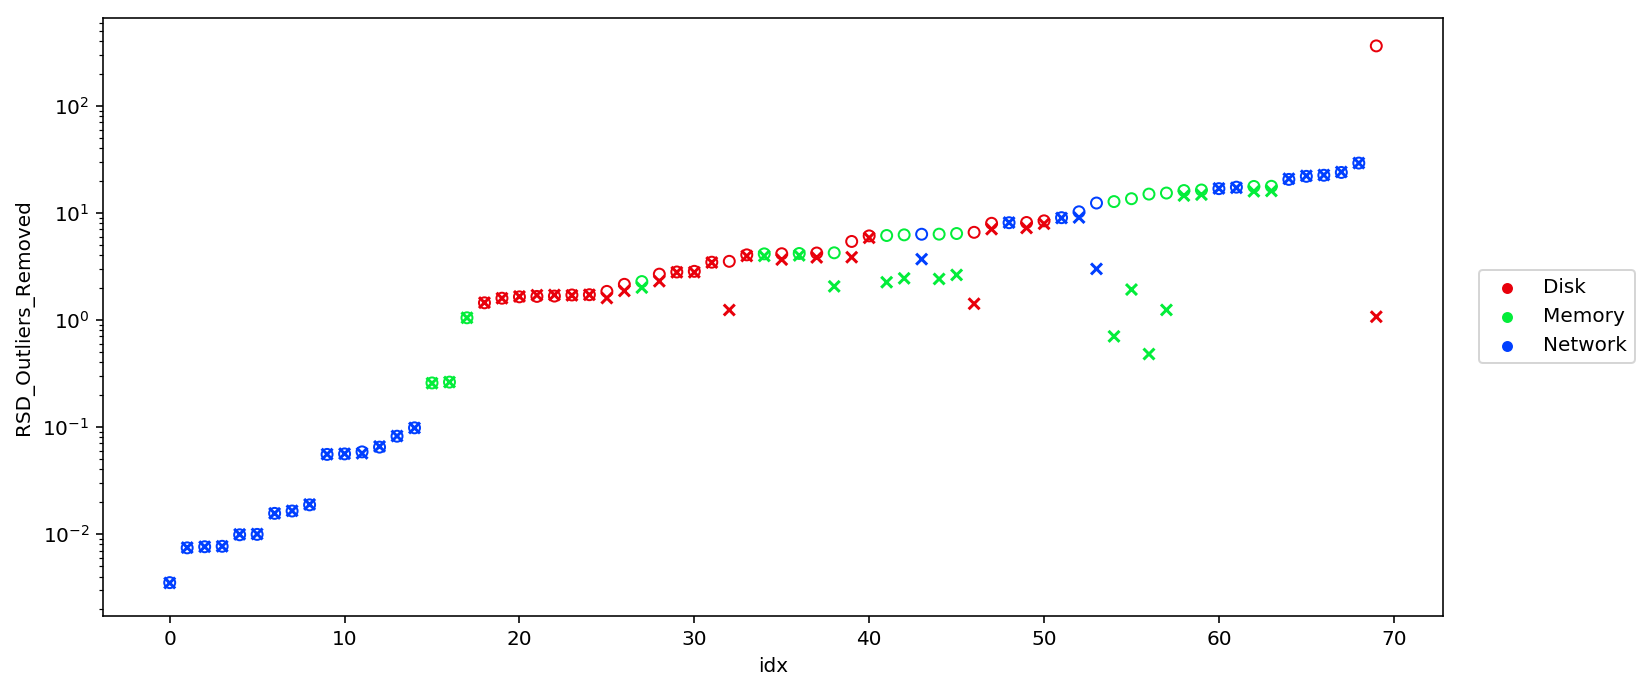

In [204]:
# Colored by type: disk, memory, network

all_summary = pd.concat([disk_var_summary, mem_var_summary, net_var_summary])
fig, ax = plt.subplots(figsize=(12,5.5))
all_summary_sorted = all_summary.sort_values("RSD")
all_summary_sorted["idx"] = range(len(all_summary_sorted))

color_map = get_cmap(all_summary_sorted, "Type")
point_color = all_summary_sorted["Type"].map(color_map)

all_summary_sorted.plot(x = "idx", y="RSD", kind="scatter", color="none", s = 30, facecolors='none', edgecolors=point_color, marker="o", ax=ax, logy=True)
all_summary_sorted.plot(x = "idx", y="RSD_Outliers_Removed", kind="scatter", color=point_color, s = 30, marker="x", ax=ax, logy=True)

for k in sorted(color_map.keys()):
    ax.scatter([], [], s=30, marker="o", color=color_map[k], lw=0.0, label=k);
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
           fancybox=True, shadow=False, ncol=1, fontsize = 10) 

plt.show()

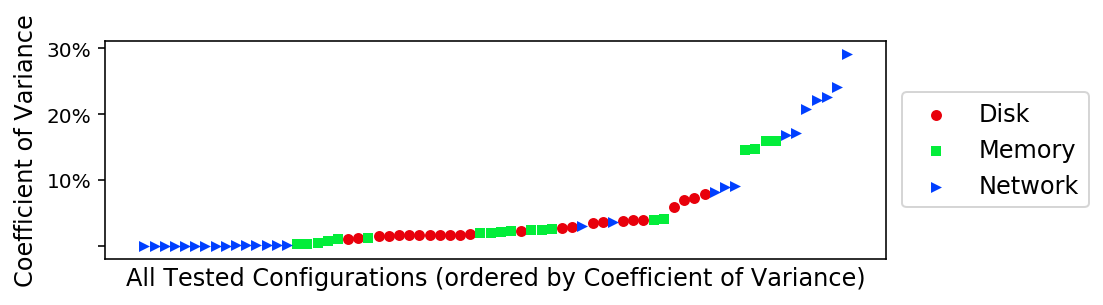

/notebooks/output/paper/cov.pdf

In [248]:
# Colored by type: disk, memory, network

all_summary = pd.concat([disk_var_summary, mem_var_summary, net_var_summary])
fig, ax = plt.subplots(figsize=(7,2.0))
all_summary_sorted = all_summary.sort_values("RSD_Outliers_Removed")
all_summary_sorted["idx"] = range(len(all_summary_sorted))

color_map = get_cmap(all_summary_sorted, "Type")
point_color = all_summary_sorted["Type"].map(color_map)

#all_summary_sorted.plot(x = "idx", y="RSD", kind="scatter", color="none", s = 30, facecolors='none', edgecolors=point_color, marker="o", ax=ax, logy=True)

#all_summary_sorted.plot(x = "idx", y="RSD_Outliers_Removed", kind="scatter", color=point_color, s = 30, marker="x", ax=ax, logy=False)

markers = {"Disk": "o", "Memory": "s", "Network": '>'}

#for k in sorted(color_map.keys()):
for k in ["Disk", "Memory", "Network"]:
    #ax.scatter([], [], s=30, marker=markers[k], color=color_map[k], lw=0.0, label=k);
    
    rel_subset = all_summary_sorted[all_summary_sorted["Type"] == k]
    ax.scatter(rel_subset.idx, rel_subset["RSD_Outliers_Removed"], s=30, marker=markers[k], color=color_map[k], lw=0.0, label=k);

ax.legend(loc='center left', bbox_to_anchor=(1.005, 0.5),
           fancybox=True, shadow=False, ncol=1, fontsize = 12) 

ax.set_ylabel("Coefficient of Variance", fontsize = 12)
ax.set_xlabel("All Tested Configurations (ordered by Coefficient of Variance)", fontsize = 12)

# Remove 0 lavel on y axis, also at percent sign
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}%'.format(x) if x > 0 else "" for x in vals], fontsize = 10)
ax.set_xticks([])

#plt.show()
plot_show_and_save(fig, "cov.pdf", dest_dir )


In [12]:
print all_summary_sorted["RSD_Change"].describe()

display(all_summary_sorted.sort_values("RSD_Outliers_Removed", ascending=False))

count     70.000000
mean      -6.637836
std       43.177828
min     -361.699880
25%       -1.555897
50%       -0.062393
75%        0.000093
max        0.299341
Name: RSD_Change, dtype: float64


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change,idx
23,Network,"[wisc, c220g1, True, latency, forward]",wisc,c220g1,70,2.630000e-02,7.669533e-03,29.161723,29.161723,0.000000,68
5,Network,"[clemson, c8220, False, latency, forward]",clemson,c8220,284,3.523239e-02,8.396251e-03,23.831056,24.088323,0.257267,67
8,Network,"[clemson, c8220, True, latency, forward]",clemson,c8220,404,3.097277e-02,6.949427e-03,22.437215,22.568032,0.130817,66
2,Network,"[clemson, c6320, False, latency, forward]",clemson,c6320,371,3.499191e-02,7.669697e-03,21.918485,22.171814,0.253329,65
20,Network,"[wisc, c220g1, False, latency, forward]",wisc,c220g1,294,2.851701e-02,5.853564e-03,20.526573,20.825914,0.299341,64
13,Network,"[utah, m510, False, bandwidth, reverse]",utah,m510,802,9.087738e+09,1.578602e+09,17.370677,17.125961,-0.244716,61
26,Network,"[wisc, c220g2, False, latency, forward]",wisc,c220g2,415,2.796145e-02,4.703114e-03,16.819996,16.912365,0.092368,60
2,Memory,"[clemson, c6320, copy, yes, 0]",clemson,c6320,741,9.840550e+03,1.741805e+03,17.700281,16.006710,-1.693571,63
3,Memory,"[clemson, c6320, copy, yes, 1]",clemson,c6320,741,9.810134e+03,1.730785e+03,17.642827,15.889956,-1.752871,62
0,Memory,"[clemson, c6320, copy, no, 0]",clemson,c6320,623,9.020895e+03,1.474153e+03,16.341541,14.784942,-1.556599,59


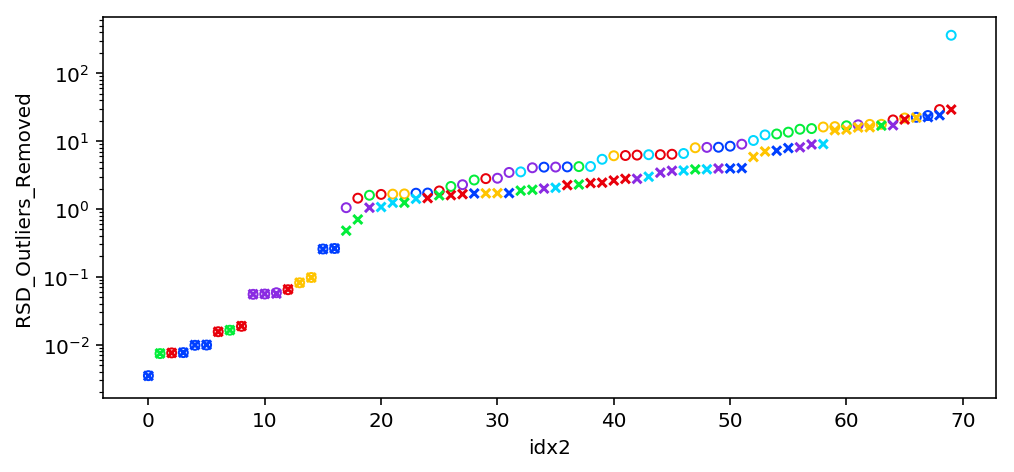

In [13]:
all_summary = pd.concat([disk_var_summary, mem_var_summary, net_var_summary])
fig, ax = plt.subplots(figsize=(8,3.5))
all_summary_sorted = all_summary.sort_values("RSD")
all_summary_sorted["idx"] = range(len(all_summary_sorted))

color_map = get_cmap(all_summary_sorted, "HW")
point_color = all_summary_sorted["HW"].map(color_map)

all_summary_sorted2 = all_summary.sort_values("RSD_Outliers_Removed")
all_summary_sorted2["idx2"] = range(len(all_summary_sorted2))
point_color2 = all_summary_sorted2["HW"].map(color_map)

all_summary_sorted.plot(x = "idx", y="RSD", kind="scatter", color="none", s = 20, facecolors='none', edgecolors=point_color, marker="o", ax=ax, logy=True)
all_summary_sorted2.plot(x = "idx2", y="RSD_Outliers_Removed", kind="scatter", color=point_color2, s = 20, marker="x", ax=ax, logy=True)

plt.show()

In [ ]:
all_summary = pd.concat([disk_var_summary, mem_var_summary, net_var_summary])
fig, ax = plt.subplots(figsize=(8,3.5))
all_summary_sorted = all_summary.sort_values("RSD")
all_summary_sorted["idx"] = range(len(all_summary_sorted))

color_map = get_cmap(all_summary_sorted, "HW")
point_color = all_summary_sorted["HW"].map(color_map)

all_summary_sorted2 = all_summary.sort_values("RSD_Outliers_Removed")
all_summary_sorted2["idx2"] = range(len(all_summary_sorted2))
point_color2 = all_summary_sorted2["HW"].map(color_map)

all_summary_sorted.plot(x = "idx", y="RSD", kind="scatter", color="none", s = 20, facecolors='none', edgecolors=point_color, marker="o", ax=ax, logy=True)
all_summary_sorted2.plot(x = "idx2", y="RSD_Outliers_Removed", kind="scatter", color=point_color2, s = 20, marker="x", ax=ax, logy=True)

plt.show()

In [14]:
# SSD versus HDD

# Based on kernel analysis, # of excluded nodes for each h_type:
# m510: 5
# c8220: 2
# m400: 7
# c220g2: 4
# c220g1: 2
# c6320: 2

node_black_list = {"c220g1-030808", "c220g1-030815", # c220g1
                   "c220g2-011312", "c220g2-011324", "c220g2-011323", "c220g2-011311", # c220g2
                   "ms0708", "ms0710", "ms0739", "ms0719", "ms0734", "ms0406", "ms0741", # m400
                   "ms0908", "ms1315", "ms1324", "ms0914", "ms0836", # m510
                   "clnode135", "clnode137", # c6320
                   "clnode036", "clnode094"} # c8220

#disk_subset = subset_df(disk_all, {"iodepth": 4096})
disk_subset = disk_all
# This time, use sdb HDDs for c220g2
hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sdb",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 20

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
        
    if not(idx[1] == "c220g2"):
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD_Outliers_Removed", ascending=False).head(show_count))
print "Average RSD_Outliers_Removed (HDD):", disk_var_summary.RSD_Outliers_Removed.mean() 


disk_subset = disk_all
# This time, use sdc SSDs for c220g2
hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sdc",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 20

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
        
    if not(idx[1] == "c220g2"):
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD_Outliers_Removed", ascending=False).head(show_count))
print "Average RSD_Outliers_Removed (SSD):", disk_var_summary.RSD_Outliers_Removed.mean() 

Number of studied disk configs: 8
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
6,Disk,"[wisc, c220g2, /dev/sdb, write, 1]",wisc,c220g2,1479,87683.952874,6877.433201,7.843434,8.393772,0.550338
4,Disk,"[wisc, c220g2, /dev/sdb, read, 1]",wisc,c220g2,1479,105526.030223,7851.321074,7.440175,7.988748,0.548573
1,Disk,"[wisc, c220g2, /dev/sdb, randread, 4096]",wisc,c220g2,1479,2896.358783,135.701088,4.685231,4.821452,0.136221
2,Disk,"[wisc, c220g2, /dev/sdb, randwrite, 1]",wisc,c220g2,1479,2410.481224,72.564311,3.010366,3.109846,0.099480
5,Disk,"[wisc, c220g2, /dev/sdb, read, 4096]",wisc,c220g2,1479,178862.979040,3883.295665,2.171101,2.395258,0.224157
7,Disk,"[wisc, c220g2, /dev/sdb, write, 4096]",wisc,c220g2,1479,181777.650439,3515.345791,1.933871,1.964815,0.030944
3,Disk,"[wisc, c220g2, /dev/sdb, randwrite, 4096]",wisc,c220g2,1479,2664.383516,47.547497,1.784559,1.746413,-0.038146
0,Disk,"[wisc, c220g2, /dev/sdb, randread, 1]",wisc,c220g2,1479,938.366754,4.392374,0.468087,0.474981,0.006893


Average RSD_Outliers_Removed (HDD): 3.86191051652
Number of studied disk configs: 8
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
0,Disk,"[wisc, c220g2, /dev/sdc, randread, 1]",wisc,c220g2,1480,29295.269257,3006.167786,10.261615,10.929798,0.668183
4,Disk,"[wisc, c220g2, /dev/sdc, read, 1]",wisc,c220g2,1480,86088.266486,5891.715426,6.843808,7.239703,0.395896
2,Disk,"[wisc, c220g2, /dev/sdc, randwrite, 1]",wisc,c220g2,1480,79563.357297,4528.981669,5.692296,6.233227,0.540932
6,Disk,"[wisc, c220g2, /dev/sdc, write, 1]",wisc,c220g2,1480,78452.074527,4548.699179,5.798061,6.222377,0.424316
7,Disk,"[wisc, c220g2, /dev/sdc, write, 4096]",wisc,c220g2,1480,450579.270270,11449.084120,2.540970,2.468474,-0.072496
5,Disk,"[wisc, c220g2, /dev/sdc, read, 4096]",wisc,c220g2,1480,493801.414189,10203.939716,2.066406,2.253290,0.186885
1,Disk,"[wisc, c220g2, /dev/sdc, randread, 4096]",wisc,c220g2,1480,305379.608108,1820.020408,0.595986,0.647403,0.051417
3,Disk,"[wisc, c220g2, /dev/sdc, randwrite, 4096]",wisc,c220g2,1480,233037.622297,1209.854961,0.519167,0.510970,-0.008197


Average RSD_Outliers_Removed (SSD): 4.56315537918


In [249]:
# SSD versus HDD -- the same analysis, for c220g1 now

# Based on kernel analysis, # of excluded nodes for each h_type:
# m510: 5
# c8220: 2
# m400: 7
# c220g2: 4
# c220g1: 2
# c6320: 2

node_black_list = {"c220g1-030808", "c220g1-030815", # c220g1
                   "c220g2-011312", "c220g2-011324", "c220g2-011323", "c220g2-011311", # c220g2
                   "ms0708", "ms0710", "ms0739", "ms0719", "ms0734", "ms0406", "ms0741", # m400
                   "ms0908", "ms1315", "ms1324", "ms0914", "ms0836", # m510
                   "clnode135", "clnode137", # c6320
                   "clnode036", "clnode094"} # c8220

#disk_subset = subset_df(disk_all, {"iodepth": 4096})
disk_subset = disk_all
# This time, use sdb HDDs for c220g2
hw2device = {"c220g1": "/dev/sdb",
             "c220g2": "/dev/sdb",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 20

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
        
    if not(idx[1] == "c220g1"):
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD_Outliers_Removed", ascending=False).head(show_count))
print "Average RSD_Outliers_Removed (HDD):", disk_var_summary.RSD_Outliers_Removed.mean() 


disk_subset = disk_all
# This time, use sdc SSDs for c220g2
hw2device = {"c220g1": "/dev/sdc",
             "c220g2": "/dev/sdc",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 20

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
        
    if not(idx[1] == "c220g1"):
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD_Outliers_Removed", ascending=False).head(show_count))
print "Average RSD_Outliers_Removed (SSD):", disk_var_summary.RSD_Outliers_Removed.mean() 

Number of studied disk configs: 8
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
4,Disk,"[wisc, c220g1, /dev/sdb, read, 1]",wisc,c220g1,763,113636.430537,6443.867725,5.670600,5.661533,-0.009067
3,Disk,"[wisc, c220g1, /dev/sdb, randwrite, 4096]",wisc,c220g1,763,2617.911494,95.506900,3.648210,3.683976,0.035766
5,Disk,"[wisc, c220g1, /dev/sdb, read, 4096]",wisc,c220g1,763,200722.672346,3833.042910,1.909621,1.927256,0.017634
7,Disk,"[wisc, c220g1, /dev/sdb, write, 4096]",wisc,c220g1,763,198891.705111,3740.701215,1.880773,1.898539,0.017766
2,Disk,"[wisc, c220g1, /dev/sdb, randwrite, 1]",wisc,c220g1,763,892.702326,8.763944,0.981732,0.987609,0.005877
1,Disk,"[wisc, c220g1, /dev/sdb, randread, 4096]",wisc,c220g1,763,3702.937051,34.113444,0.921254,0.928377,0.007123
0,Disk,"[wisc, c220g1, /dev/sdb, randread, 1]",wisc,c220g1,763,1006.706328,5.801790,0.576314,0.582287,0.005973
6,Disk,"[wisc, c220g1, /dev/sdb, write, 1]",wisc,c220g1,763,697.141666,1.002406,0.143788,0.141347,-0.002441


Average RSD_Outliers_Removed (HDD): 1.9763654469
Number of studied disk configs: 8
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
0,Disk,"[wisc, c220g1, /dev/sdc, randread, 1]",wisc,c220g1,765,29938.751242,2970.017237,9.920311,9.859031,-0.061280
4,Disk,"[wisc, c220g1, /dev/sdc, read, 1]",wisc,c220g1,765,99341.454641,5322.121599,5.357403,5.379332,0.021930
2,Disk,"[wisc, c220g1, /dev/sdc, randwrite, 1]",wisc,c220g1,765,90997.144444,4218.346364,4.635691,4.653742,0.018051
6,Disk,"[wisc, c220g1, /dev/sdc, write, 1]",wisc,c220g1,765,89450.062745,3601.359511,4.026112,3.949173,-0.076939
7,Disk,"[wisc, c220g1, /dev/sdc, write, 4096]",wisc,c220g1,765,449629.726797,4438.911064,0.987237,0.997655,0.010418
5,Disk,"[wisc, c220g1, /dev/sdc, read, 4096]",wisc,c220g1,765,489668.043137,3276.814951,0.669191,0.675761,0.006570
3,Disk,"[wisc, c220g1, /dev/sdc, randwrite, 4096]",wisc,c220g1,765,234180.296732,1252.107054,0.534677,0.533137,-0.001539
1,Disk,"[wisc, c220g1, /dev/sdc, randread, 4096]",wisc,c220g1,765,305628.045752,288.509973,0.094399,0.094760,0.000361


Average RSD_Outliers_Removed (SSD): 3.26782401354


In [16]:
# SSD versus HDD -- the same analysis, for m400 (SSD only)

# Based on kernel analysis, # of excluded nodes for each h_type:
# m510: 5
# c8220: 2
# m400: 7
# c220g2: 4
# c220g1: 2
# c6320: 2

node_black_list = {"c220g1-030808", "c220g1-030815", # c220g1
                   "c220g2-011312", "c220g2-011324", "c220g2-011323", "c220g2-011311", # c220g2
                   "ms0708", "ms0710", "ms0739", "ms0719", "ms0734", "ms0406", "ms0741", # m400
                   "ms0908", "ms1315", "ms1324", "ms0914", "ms0836", # m510
                   "clnode135", "clnode137", # c6320
                   "clnode036", "clnode094"} # c8220

#disk_subset = subset_df(disk_all, {"iodepth": 4096})
disk_subset = disk_all
# This time, use sdb HDDs for c220g2
hw2device = {"c220g1": "/dev/sdb",
             "c220g2": "/dev/sdb",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 20

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
        
    if not(idx[1] == "m400"):
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD_Outliers_Removed", ascending=False).head(show_count))
print "Average RSD_Outliers_Removed (HDD):", disk_var_summary.RSD_Outliers_Removed.mean() 

Number of studied disk configs: 8
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
5,Disk,"[utah, m400, /dev/sda2, read, 4096]",utah,m400,3566,189514.713685,10237.490710,5.401950,3.848160,-1.553790
4,Disk,"[utah, m400, /dev/sda2, read, 1]",utah,m400,3566,74719.263657,4877.748399,6.528100,1.554901,-4.973199
1,Disk,"[utah, m400, /dev/sda2, randread, 4096]",utah,m400,3566,97985.256225,6441.059864,6.573499,1.414080,-5.159419
0,Disk,"[utah, m400, /dev/sda2, randread, 1]",utah,m400,3566,73864.292961,3674.978978,4.975312,1.375847,-3.599465
7,Disk,"[utah, m400, /dev/sda2, write, 4096]",utah,m400,3566,119414.075070,4206.406420,3.522538,1.236318,-2.286220
6,Disk,"[utah, m400, /dev/sda2, write, 1]",utah,m400,3566,2733.429226,8696.932351,318.169290,1.082790,-317.086499
3,Disk,"[utah, m400, /dev/sda2, randwrite, 4096]",utah,m400,3566,2915.537863,10576.674364,362.769234,1.069353,-361.699880
2,Disk,"[utah, m400, /dev/sda2, randwrite, 1]",utah,m400,3566,2722.792420,8595.138328,315.673654,1.068780,-314.604874


Average RSD_Outliers_Removed (HDD): 1.58127872963


In [17]:
# SSD versus HDD -- the same analysis, for m510 (NVME only)

# Based on kernel analysis, # of excluded nodes for each h_type:
# m510: 5
# c8220: 2
# m400: 7
# c220g2: 4
# c220g1: 2
# c6320: 2

node_black_list = {"c220g1-030808", "c220g1-030815", # c220g1
                   "c220g2-011312", "c220g2-011324", "c220g2-011323", "c220g2-011311", # c220g2
                   "ms0708", "ms0710", "ms0739", "ms0719", "ms0734", "ms0406", "ms0741", # m400
                   "ms0908", "ms1315", "ms1324", "ms0914", "ms0836", # m510
                   "clnode135", "clnode137", # c6320
                   "clnode036", "clnode094"} # c8220

#disk_subset = subset_df(disk_all, {"iodepth": 4096})
disk_subset = disk_all
# This time, use sdb HDDs for c220g2
hw2device = {"c220g1": "/dev/sdb",
             "c220g2": "/dev/sdb",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

metric = "mean"
show_count = 20

# ----
c = 0
disk_var_summary = pd.DataFrame(columns=["Type", "Config", "Site", "HW", "SampleCount", "Mean", "SD", "RSD", "RSD_Outliers_Removed", "RSD_Change"])
for idx, grp in disk_subset.groupby(["site", "hw_type", "device", "testname", "iodepth"]): 
    
    # Skip configs for devices that aren't boot drives
    if hw2device[idx[1]] != idx[2]:
        continue
        
    if not(idx[1] == "m510"):
        continue
    
    sd = grp[metric].std()
    m = grp[metric].mean()
    rsd = (sd/m) * 100
    #disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd] 
    
    grp_filtered = grp[~grp.nodeid.isin(node_black_list)]
    sd_filtered = grp_filtered[metric].std()
    m_filtered = grp_filtered[metric].mean()
    rsd_filtered = (sd_filtered/m_filtered) * 100
    disk_var_summary.loc[len(disk_var_summary)] = ["Disk", list(idx), idx[0], idx[1], len(grp), m, sd, rsd, rsd_filtered, rsd_filtered-rsd] 

    c += 1
    
print "Number of studied disk configs:", c

print "Highest RSD for disks:"    
display(disk_var_summary.sort_values("RSD_Outliers_Removed", ascending=False).head(show_count))
print "Average RSD_Outliers_Removed (HDD):", disk_var_summary.RSD_Outliers_Removed.mean() 

Number of studied disk configs: 8
Highest RSD for disks:


,Type,Config,Site,HW,SampleCount,Mean,SD,RSD,RSD_Outliers_Removed,RSD_Change
6,Disk,"[utah, m510, /dev/nvme0n1p4, write, 1]",utah,m510,2006,1.798023e+05,13052.022435,7.259098,6.990250,-0.268848
4,Disk,"[utah, m510, /dev/nvme0n1p4, read, 1]",utah,m510,2006,1.921338e+05,13852.694859,7.209922,6.915491,-0.294431
2,Disk,"[utah, m510, /dev/nvme0n1p4, randwrite, 1]",utah,m510,2006,1.752430e+05,11632.339084,6.637833,6.316504,-0.321329
5,Disk,"[utah, m510, /dev/nvme0n1p4, read, 4096]",utah,m510,2006,7.813807e+05,31642.798185,4.049601,3.951246,-0.098354
1,Disk,"[utah, m510, /dev/nvme0n1p4, randread, 4096]",utah,m510,2006,1.106820e+06,45914.788931,4.148353,3.657104,-0.491249
3,Disk,"[utah, m510, /dev/nvme0n1p4, randwrite, 4096]",utah,m510,2006,6.566351e+05,22698.389070,3.456773,3.431547,-0.025227
7,Disk,"[utah, m510, /dev/nvme0n1p4, write, 4096]",utah,m510,2006,7.810511e+05,22184.642267,2.840357,2.784824,-0.055534
0,Disk,"[utah, m510, /dev/nvme0n1p4, randread, 1]",utah,m510,2006,6.639630e+04,1617.211339,2.435695,2.349312,-0.086383


Average RSD_Outliers_Removed (HDD): 4.54953477589
